In [1]:

#Librerías
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
 


import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from google.colab import data_table
import warnings
warnings.filterwarnings('ignore')

import pickle

#Lectura de tablas
from google.colab import data_table
data_table.enable_dataframe_formatter()
#Montar GDRIVE
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [14]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
articulos = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/articles.csv",index_col=0)
clientes = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/customers.csv",index_col=0)
transacciones = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/transactions_train.csv",index_col=0)
usuarios_test=pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/users_test.csv",index_col=0)

In [ ]:
#!unzip '/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/images_rescaled.zip' -d '/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/images_rescaled1'
images_dir = '/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/images_rescaled1/images_reescaled'

# Articulos

1.   article_id: Id del articulo
2. product_code: Codigo articulo
3.   prod_name: Nombre articulo
4. product_type_no: Numero del tipo de articulo
5. prod_name: Nombre articulo
6. product_type_no: Numero del tipo de articulo 
7. product_type_name: Nombre del tipo de artículo
8. product_group_name: Nombre del grupo del artículo
9. graphical_appearance_no: Numero apariencia grafica 
10. graphical_appearance_name: 	Nombre apariencia grafica
11. colour_group_code: Codigo del grupo de color de item	
12. colour_group_name:	Nombre del grupo de color de item
13. department_no:	Numero departamento
14. department_name: Nombre departamento
15. section_no:	Numero seccion
16. garment_group_name:	Nombre del grupo del item
17. detail_desc:Descripcion item




In [ ]:
articulos.head()

In [ ]:
# Numero de registros únicos en cada columna
for col in articulos.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articulos[col].nunique()
        print(f'n of unique {col}: {un_n}')

In [ ]:
#Productos dentro de cada categoría de grupo
pd.options.display.max_rows = None
articulos.groupby(['product_group_name', 'product_type_name']).count()['article_id']

In [ ]:
#Categoría de productos (product_group_name)
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articulos, y='product_group_name', color='blue')
ax.set_xlabel('count by product_group_name')
ax.set_ylabel('product_group_name')
plt.show()

In [ ]:
#Departamento al que pertenece producto (department_name)
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articulos, y='department_name', color='blue')
ax.set_xlabel('count by department_name')
ax.set_ylabel('department_name')
plt.show()

In [ ]:
#Nombre del grupo del producto
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articulos, y='garment_group_name', color='blue')
ax.set_xlabel('count by garment_group_name')
ax.set_ylabel('garment_group_name')
plt.show()

In [ ]:
#Tipo de productos
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articulos, y='section_name', color='blue')
ax.set_xlabel('count by section_name')
ax.set_ylabel('section_name')
plt.show()

# Clientes

1. customer_id: id del usuario
2. club_member_status: estado de su membresía
3. age: edad
4. postal_code: codigo postal


In [ ]:
pd.options.display.max_rows = 50
clientes.head


In [ ]:
#No hay Id de cleintes repetidos
clientes.shape[0] - clientes['customer_id'].nunique()

In [ ]:
#Agrupamiento por codigo postal
codigo_postal_unico = clientes.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
codigo_postal_unico

In [ ]:
#Distribución edad
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=clientes, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution de edad de clientes')
plt.show()

In [ ]:
#Status de membresía
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=clientes, x='club_member_status', color='orange')
ax.set_xlabel('Distribution of club member status')
plt.show()

# Transacciones

1. customer_id: id del usuario
2. article_id: el id del artículo
3. t_dat: la fecha de la transacción
4. price: el precio del articulo
5. sales_channel_id: Id del canal de venta

In [ ]:
pd.options.display.max_rows = 50
transacciones.head

In [ ]:
#Trabajo imágenes
def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

def preprocess_img(img_path):
    dsize = (225,225)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=preprocess_input(new_image)
    return new_image

def load_data():
    output=[]
    output=getImagePaths(images_dir)[:10000]
    return output

In [ ]:
#Definición modelo y extracción de features
def model():
    model=ResNet50(weights='imagenet',include_top=False)
    for layer in model.layers:
        layer.trainable=False
        #model.summary()
    return model

def feature_extraction(image_data,model):
    features=model.predict(image_data)
    features=np.array(features)
    features=features.flatten()
    return features

In [ ]:
# Encontrar imagen similar a través de vecinos cercanos y similaridad coseno

def result_vector_cosine(model,feature_vector,new_img):
    new_feature = model.predict(new_img)
    new_feature = np.array(new_feature)
    new_feature = new_feature.flatten()
    N_result = 12
    nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    return(indices)

In [ ]:
def input_show(data):
    plt.title("Imagen")
    plt.imshow(data)
  
def show_result(data,result):
    fig = plt.figure(figsize=(12,8))
    for i in range(0,12):
        index_result=result[0][i]
        plt.subplot(3,4,i+1)
        plt.imshow(cv2.imread(data[index_result]))
    plt.show()

def main():  
    features=[]
    output=load_data()
    main_model=model()
    #Limiting the data for training
    for i in output[:999]:
        new_img=preprocess_img(i)
        features.append(feature_extraction(new_img,main_model))
    feature_vec = np.array(features)
    result=result_vector_cosine(main_model,feature_vec,preprocess_img(output[200]))
    input_show(cv2.imread(output[200]))
    show_result(output,result)
  

if __name__=='__main__':
    main()

In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # remove this case in advance
    # if not actual:
    #     return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def getNDCG(recommend_list, gt_item):
    idx = np.where(recommend_list == gt_item)[0]
    if len(idx) > 0:
        return math.log(2)/math.log(idx+2)
    else:
        return 0




#Análisis Most Popular para los 10 ítems





In [ ]:

#10 Most Popular items

#Bases a usar


transacciones = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/transactions_train.csv",sep=',', usecols= ['t_dat', 'customer_id', 'article_id'], dtype={'article_id': 'int32'})
clientes = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/customers.csv",sep=',', usecols= ['customer_id'])

print(transacciones['article_id'].nunique())

73080


In [ ]:
#Filtrar por # de articulos para sacar aquellos menos vendidos, se visualizara distribucion: Se toman aquellos articulos donde al menos existan más de 10 art. vendidos

articulos_vendidos = transacciones[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})

print(articulos_vendidos)

'''
plt.plot(articulos_vendidos['article_id'] , articulos_vendidos['count']) 
plt.xlabel('article') 
plt.ylabel('count') 
plt.title('Frecuencias productos') 
plt.show() 


np.percentile(articulos_vendidos['count'],45)
'''

       article_id  count
0       108775015    550
1       108775044    359
2       108775051     10
3       110065001     48
4       110065002     26
...           ...    ...
73075   946748004     11
73076   946764003      4
73077   946827001      3
73078   947509001      3
73079   948152002      1

[73080 rows x 2 columns]


"\nplt.plot(articulos_vendidos['article_id'] , articulos_vendidos['count']) \nplt.xlabel('article') \nplt.ylabel('count') \nplt.title('Frecuencias productos') \nplt.show() \n\n\nnp.percentile(articulos_vendidos['count'],45)\n"

In [ ]:

articulos_mas_vendidos = articulos_vendidos[articulos_vendidos['count']>20]['article_id'].values
transacciones= transacciones[transacciones['article_id'].isin(articulos_mas_vendidos)]

print(transacciones['article_id'].nunique())


'''
article_bought_count = transactions[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
most_bought_articles = article_bought_count[article_bought_count['count']>10]['article_id'].values
transactions = transactions[transactions['article_id'].isin(most_bought_articles)]
'''

17337


"\narticle_bought_count = transactions[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})\nmost_bought_articles = article_bought_count[article_bought_count['count']>10]['article_id'].values\ntransactions = transactions[transactions['article_id'].isin(most_bought_articles)]\n"

In [ ]:
#Split Train Test
test_start_date = '2020-04-28'

train_df = transacciones.query(f"t_dat < '{test_start_date}'").reset_index(drop=True)
test_df = transacciones.query(f"t_dat >= '{test_start_date}'").reset_index(drop=True)

#Ordenar 
train_df = train_df.sort_values(["customer_id", "t_dat"], ascending=False)
test_df = test_df.sort_values(["customer_id", "t_dat"], ascending=False)

In [ ]:
train_df

t_dat                                        customer_id  \
47465   2019-12-22  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   
47464   2019-12-01  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   
47462   2019-10-02  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   
47463   2019-10-02  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   
47461   2019-09-22  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   
...            ...                                                ...   
534129  2018-12-20  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
534130  2018-12-20  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
534131  2018-12-20  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
534132  2018-12-20  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
534123  2018-10-21  000226b9ea81019249060b376b516f821a80e9b24f89a7...   

        article_id  
47465    789119002  
47464    755362001  
47462    752516005  
47463    752516003  
47461    773989001  
...            ...  
534129   678977001  
534130   678977001  
534131   624148001  
534132   633825004  
534123   664485002  

[1167534 rows x 3 columns]

In [ ]:
#Ordenar las bases
test_df=test_df.sort_values(['customer_id', 't_dat'], ascending = [True, True]) 

test_cust=test_df.groupby('customer_id')['article_id'].apply(list).reset_index()

test_cust['test_true'] = test_cust['article_id'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))

#del test_df, test_cust['article_id']

In [ ]:
test_cust

customer_id  \
0      000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
1      000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   
2      000989f72a2b8e5da2f4abafc86c2e213816fa2ff2a060...   
3      000a5f3c8be9167cb0d09dd8a17b6b54998e9e83faaf52...   
4      00166640b52138ab8e804f5e3b1fabdc4a4f696db21e17...   
...                                                  ...   
14467  ffea502f8d05474b080f3bfef3a9eb3b62c5cb6326a319...   
14468  ffef4cff53247fdc32126ece22579ed9a99dae34436659...   
14469  ffef84ca20f47fe7300bf49e3f1057c15ef3101b510d59...   
14470  fff871bf24b40fd1290215414d760afaa69bb164d2b970...   
14471  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   

                                              article_id  \
0                                 [850176003, 688537004]   
1      [706016002, 706016001, 820827002, 700926002, 3...   
2      [589549011, 488561003, 685814003, 570002013, 5...   
3      [860322002, 886241003, 907613001, 889010001, 8...   
4      [832309007, 351484033, 589599010, 631878001, 8...   
...                                                  ...   
14467  [762188002, 859105003, 859105003, 825210001, 8...   
14468       [749615012, 806528005, 745073002, 695545002]   
14469                  [892093002, 868642001, 861847005]   
14470       [858565001, 858565002, 841173002, 825550001]   
14471  [867023001, 806388002, 806388001, 806388003, 8...   

                                               test_true  
0                                  0850176003 0688537004  
1      0706016002 0706016001 0820827002 0700926002 03...  
2      0589549011 0488561003 0685814003 0570002013 05...  
3      0860322002 0886241003 0907613001 0889010001 08...  
4      0832309007 0351484033 0589599010 0631878001 08...  
...                                                  ...  
14467  0762188002 0859105003 0859105003 0825210001 08...  
14468        0749615012 0806528005 0745073002 0695545002  
14469                   0892093002 0868642001 0861847005  
14470        0858565001 0858565002 0841173002 0825550001  
14471  0867023001 0806388002 0806388001 0806388003 08...  

[14472 rows x 3 columns]

In [ ]:
#Cambia formato de recomendación
test_cust['test_true'] = test_cust['article_id'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))

In [ ]:
#Selección de los 10 ítems más populares en testing (80% muestra)
n_items=10
desde_fecha= "2020-04-28"
top_n_items=transacciones[transacciones['t_dat'] < desde_fecha].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(n_items).index.tolist()

top_n_items = ['0' + str(item) for item in top_n_items]

prediccion_most_popular=clientes.copy()

prediccion_most_popular['prediccion'] = ' '.join(top_n_items)



In [ ]:
#ïtems más populares
top_n_items

['0706016001',
 '0706016002',
 '0372860001',
 '0610776002',
 '0759871002',
 '0673677002',
 '0673396002',
 '0562245001',
 '0399223001',
 '0464297007']

In [ ]:
#Predicción más popular sobre test
prediccion_most_popular = test_cust.merge(prediccion_most_popular, on ='customer_id', how ='left')

In [ ]:
#Dataframe con artículos comprados reales vs los 10 más populares
prediccion_most_popular.head(2)

customer_id  \
0  000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
1  000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   

                                          article_id  \
0                             [850176003, 688537004]   
1  [706016002, 706016001, 820827002, 700926002, 3...   

                                           test_true  Unnamed: 0  \
0                              0850176003 0688537004           1   
1  0706016002 0706016001 0820827002 0700926002 03...           4   

  club_member_status   age                                        postal_code  \
0             ACTIVE  34.0  3e352138284f73c8b2e19d5aa0d090ec976824c28b0215...   
1             ACTIVE  29.0  72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...   

                                          prediccion  
0  0706016001 0706016002 0372860001 0610776002 07...  
1  0706016001 0706016002 0372860001 0610776002 07...

In [ ]:
#Cálculo de MAPK en test para 10 artículos más populares en test
mapk(
    prediccion_most_popular['test_true'].map(lambda x: x.split()), 
    prediccion_most_popular['prediccion'].map(lambda x: x.split()), 
    k=10
)

0.003082491349835186

#Modelo ALS

In [2]:
#Cargar Librería
!pip install --upgrade implicit
import implicit
from scipy.sparse import coo_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 4.8 MB/s 


In [3]:
#Cargar Bases
trans = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/transactions_train.csv",  dtype={'article_id': str}, parse_dates=['t_dat'])
clientes = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/customers.csv")
articulos = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/articles.csv",dtype={'article_id': str})


In [ ]:
print(len(trans['user_id']))
trans

1318501


Unnamed: 0      t_dat  \
0                 0 2018-11-28   
1                 1 2018-11-28   
2                 2 2019-03-28   
3                 3 2019-03-28   
4                 4 2019-03-28   
...             ...        ...   
1318496     1318496 2019-09-10   
1318497     1318497 2019-09-20   
1318498     1318498 2019-09-20   
1318499     1318499 2019-09-20   
1318500     1318500 2019-09-22   

                                               customer_id article_id  \
0        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  655265001   
1        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  537688014   
2        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  698877002   
3        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  382127027   
4        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  610776001   
...                                                    ...        ...   
1318496  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  751478002   
1318497  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  750444005   
1318498  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  811198001   
1318499  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  787880005   
1318500  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  731521005   

            price  sales_channel_id  user_id  item_id  
0        0.025407                 2     5563    24828  
1        0.050831                 2     5563     6231  
2        0.042356                 2     5563    35798  
3        0.032186                 2     5563     1351  
4        0.008458                 2     5563    15373  
...           ...               ...      ...      ...  
1318496  0.042356                 2    10627    48957  
1318497  0.059305                 1    10627    48753  
1318498  0.033881                 1    10627    61396  
1318499  0.050831                 1    10627    56719  
1318500  0.033881                 2    10627    43688  

[1318501 rows x 8 columns]

In [4]:
#Filtrar por # de articulos para sacar aquellos menos vendidos. Se toman aquellos articulos donde al menos existan más de 10 art. vendidos
articulos_vendidos = trans[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
articulos_mas_vendidos = articulos_vendidos[articulos_vendidos['count']>10]['article_id'].values
trans= trans[trans['article_id'].isin(articulos_mas_vendidos)]

print(trans['article_id'].nunique())

print(articulos_vendidos)

27724
      article_id  count
0      108775015    550
1      108775044    359
2      108775051     10
3      110065001     48
4      110065002     26
...          ...    ...
73075  946748004     11
73076  946764003      4
73077  946827001      3
73078  947509001      3
73079  948152002      1

[73080 rows x 2 columns]


In [ ]:
#Filtrar por usuarios que hayan realizado al menos más de 10 compras
'''compras_realizadas = trans[['customer_id', 't_dat']].groupby('customer_id').count().reset_index().rename(columns={'t_dat': 'count'})
clientes_mas_compras = compras_realizadas[compras_realizadas['count']>10]['customer_id'].values
trans= trans[trans['customer_id'].isin(clientes_mas_compras)]
'''

In [16]:
#Se revisará estacionalidad de ventas
trans_mes=trans.copy()
trans_mes['mes']=trans['t_dat'].dt.month
trans_mes['mes'].value_counts().sort_values(axis=0,ascending=False)
ventas_mes=trans_mes['mes'].value_counts().sort_values(axis=0,ascending=False)
print(ventas_mes)

6     128433
5     111412
4     108045
7     101368
10    100941
11     99568
3      94480
1      94377
12     87680
2      84119
9      77821
8      66750
Name: mes, dtype: int64


In [6]:
#Cruce de items y transacciones (para ver en que temporada se usan que productos). Se supone hemisferio norte

columnas_art=['prod_name', 'article_id','product_group_name','garment_group_name']
art=articulos[columnas_art]

columnas_trans=['t_dat', 'article_id']
tra=trans[columnas_trans]

art_tra=pd.merge(art,tra,on='article_id')
#ver venta de articulos por temporada

primavera=art_tra[art_tra.t_dat.dt.month.isin([4, 5, 6])]
verano=art_tra[art_tra.t_dat.dt.month.isin([7, 8, 9])]
otono=art_tra[art_tra.t_dat.dt.month.isin([10, 11, 12])]
invierno=art_tra[art_tra.t_dat.dt.month.isin([1, 2, 3])]

In [8]:

from wordcloud import WordCloud
#Primavera
text_primavera_producto= " ".join(cat for cat in primavera.prod_name)
text_primavera_categoria= " ".join(cat for cat in primavera.product_group_name)
text_primavera_grupo= " ".join(cat for cat in primavera.garment_group_name)

#Verano
text_verano_producto=" ".join(cat for cat in verano.prod_name)
text_verano_categoria= " ".join(cat for cat in verano.product_group_name)
text_verano_grupo= " ".join(cat for cat in verano.garment_group_name)

#Otono
text_otono_producto=" ".join(cat for cat in otono.prod_name)
text_otono_categoria=" ".join(cat for cat in otono.product_group_name)
text_otono_grupo= " ".join(cat for cat in otono.garment_group_name)

#Invierno
text_invierno_producto=" ".join(cat for cat in invierno.prod_name)
text_invierno_categoria=" ".join(cat for cat in invierno.product_group_name)
text_invierno_grupo= " ".join(cat for cat in invierno.garment_group_name)


def cloud(a): 
  wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=None,
        ).generate(a)

  plt.imshow(wordcloud)

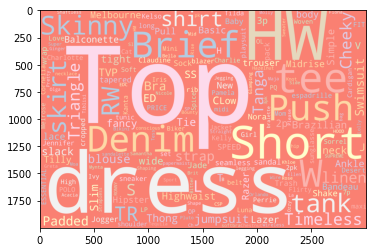

In [ ]:
cloud(text_primavera_producto)

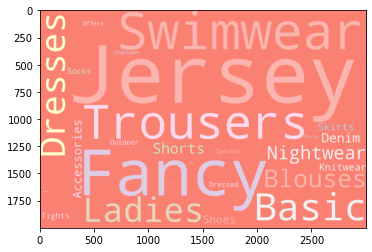

In [9]:
cloud(text_primavera_grupo)

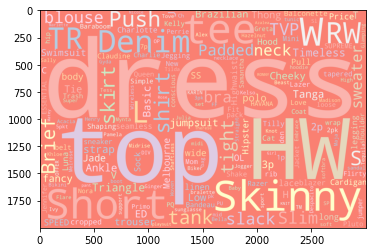

In [ ]:
cloud(text_verano_producto)

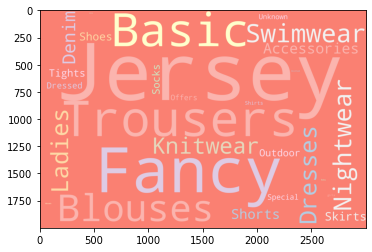

In [11]:
cloud(text_verano_grupo)

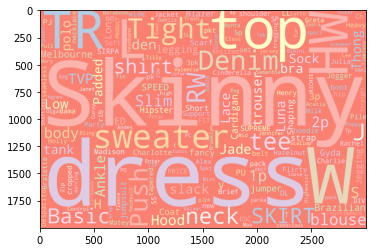

In [ ]:
cloud(text_otono_producto)

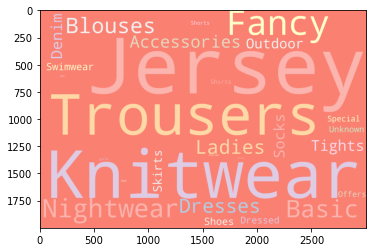

In [12]:
cloud(text_otono_grupo)

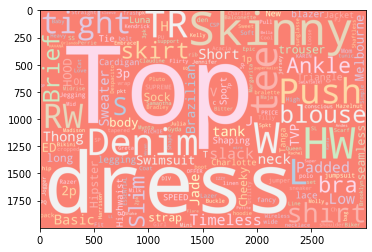

In [ ]:
cloud(text_invierno_producto)

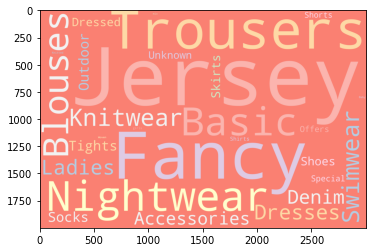

In [13]:
cloud(text_invierno_grupo)

In [ ]:
#Ver promedio de transacciones por usuario




In [ ]:
#Rearreglar ids
usuarios_unicos = clientes['customer_id'].unique().tolist()#
articulos_unicos = articulos['article_id'].unique().tolist()#

cliente_ids = dict(list(enumerate(usuarios_unicos)))
articulo_ids = dict(list(enumerate(articulos_unicos)))

mapa_cliente = {u: uidx for uidx, u in cliente_ids.items()}
mapa_articulo = {i: iidx for iidx, i in articulo_ids.items()}

trans['user_id'] = trans['customer_id'].map(mapa_cliente)
trans['item_id'] = trans['article_id'].map(mapa_articulo)

In [ ]:
#Jugar con fechas para mejorar performance...

#Todo el dataset

print(trans.shape)
print(trans['t_dat'].max())
print(trans['t_dat'].min())


# Entrenamiento 80% data, desde inicio 20-09-2018 hasta 28-04-2020 y validación 10%
trans_train=trans[trans.t_dat.between('2018-09-20','2020-04-28')]
print(trans_train['t_dat'].max())
print(trans_train['t_dat'].min())


# Test 20% data
trans_test=trans[trans.t_dat.between('2020-04-29','2020-09-22')]
print(trans_test['t_dat'].max())
print(trans_test['t_dat'].min())


#trans = trans[trans['t_dat'] > '2020-08-21']


(1318501, 8)
2020-09-22 00:00:00
2018-09-20 00:00:00
2020-04-28 00:00:00
2018-09-20 00:00:00
2020-09-22 00:00:00
2020-04-29 00:00:00


In [ ]:
train=len(trans_train['user_id'])
test=len(trans_test['user_id'])
print(train)
print(test)

1168624
149877


In [ ]:
train=len(trans_train['user_id'].unique())
test=len(trans_test['user_id'].unique())
print(train)
print(test)


42321
13927


In [ ]:
trans

Unnamed: 0      t_dat  \
0                 0 2018-11-28   
1                 1 2018-11-28   
4                 4 2019-03-28   
5                 5 2019-05-17   
6                 6 2019-10-03   
...             ...        ...   
1318493     1318493 2019-08-21   
1318495     1318495 2019-09-10   
1318497     1318497 2019-09-20   
1318498     1318498 2019-09-20   
1318499     1318499 2019-09-20   

                                               customer_id article_id  \
0        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  655265001   
1        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  537688014   
4        1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...  610776001   
5        b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...  647826001   
6        b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...  754697001   
...                                                    ...        ...   
1318493  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  792604001   
1318495  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  772902001   
1318497  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  750444005   
1318498  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  811198001   
1318499  3c0c198b6c04d50b639ca8128c3010603f34b37896bbf8...  787880005   

            price  sales_channel_id  user_id  item_id  
0        0.025407                 2     5563    24828  
1        0.050831                 2     5563     6231  
4        0.008458                 2     5563    15373  
5        0.016932                 2    31806    23178  
6        0.017610                 2    31806    49817  
...           ...               ...      ...      ...  
1318493  0.025407                 1    10627    57588  
1318495  0.013542                 2    10627    53868  
1318497  0.059305                 1    10627    48753  
1318498  0.033881                 1    10627    61396  
1318499  0.050831                 1    10627    56719  

[1154994 rows x 8 columns]

In [ ]:
#Crear matriz sparse

fila=trans_train['user_id'].values
columna=trans_train['item_id'].values
data=np.ones(trans_train.shape[0])

sparse= coo_matrix((data, (fila, columna)), shape=(len(usuarios_unicos), len(articulos_unicos)))

sparse


<45000x77650 sparse matrix of type '<class 'numpy.float64'>'
	with 1034245 stored elements in COOrdinate format>

In [ ]:
#Probar que funciona modelo
model = implicit.als.AlternatingLeastSquares(factors=5, iterations=2)
model.fit(sparse)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#Funciones a usar (df=trans)

def to_user_item_coo(trans):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    fila = trans['user_id'].values
    col = trans['item_id'].values
    data = np.ones(trans.shape[0])
    sparse= coo_matrix((data, (fila, col)), shape=(len(usuarios_unicos), len(articulo_ids)))
    return sparse

def split_data(trans, validation_days=117):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = trans['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = trans[trans['t_dat'] < validation_cut]
    df_val = trans[trans['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(trans, validation_days=117):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(trans, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    

    # TODO: change MAP@10 to a library that allows repeated items in prediction
    map10 = mean_average_precision_at_k(model, csr_train, csr_val, K=10, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@10: {map10:6.5f}")
    return map10




In [ ]:
matrices = get_val_matrices(trans_train)

In [ ]:
matrices

{'coo_train': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 1033284 stored elements in COOrdinate format>,
 'csr_train': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 876919 stored elements in Compressed Sparse Row format>,
 'csr_val': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 841 stored elements in Compressed Sparse Row format>}

In [ ]:
%%time

from implicit.evaluation import mean_average_precision_at_k

best_map10 = 0
for factors in [5,15, 30, 60, 90,120]:
    for iterations in [30, 60, 90]:
        for regularization in [0.01, 0.05, 0.1]:
            map10 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map10 > best_map10:
                best_map10 = map10
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:   5 - Iterations: 30 - Regularization: 0.010 ==> MAP@10: 0.00182
Best MAP@12 found. Updating: {'factors': 5, 'iterations': 30, 'regularization': 0.01}
Factors:   5 - Iterations: 30 - Regularization: 0.050 ==> MAP@10: 0.00182
Factors:   5 - Iterations: 30 - Regularization: 0.100 ==> MAP@10: 0.00182
Factors:   5 - Iterations: 60 - Regularization: 0.010 ==> MAP@10: 0.00233
Best MAP@12 found. Updating: {'factors': 5, 'iterations': 60, 'regularization': 0.01}
Factors:   5 - Iterations: 60 - Regularization: 0.050 ==> MAP@10: 0.00233
Factors:   5 - Iterations: 60 - Regularization: 0.100 ==> MAP@10: 0.00233
Factors:   5 - Iterations: 90 - Regularization: 0.010 ==> MAP@10: 0.00233
Factors:   5 - Iterations: 90 - Regularization: 0.050 ==> MAP@10: 0.00233
Factors:   5 - Iterations: 90 - Regularization: 0.100 ==> MAP@10: 0.00233
Factors:  15 - Iterations: 30 - Regularization: 0.010 ==> MAP@10: 0.00393
Best MAP@12 found. Updating: {'factors': 15, 'iterations': 30, 'regularization': 0.01}
F

In [ ]:
best_params

{'factors': 15, 'iterations': 30, 'regularization': 0.01}

In [ ]:
# Entrenando sobre todo el dataset de train

coo_train = to_user_item_coo(trans_train)
csr_train = coo_train.tocsr()


def train(coo_train, factors=15, iterations=30, regularization=0.01, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model




In [ ]:
modelo = train(coo_train, **best_params)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# Se ejecutará modelo sobre test
coo_test = to_user_item_coo(trans_test)
csr_test = coo_test.tocsr()



In [ ]:
def recomendacion(modelo, csr_test, reco_name="recos.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(usuarios_unicos))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = modelo.recommend(batch, csr_train[batch], N=10, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = cliente_ids[userid]
            user_items = ids[i]
            article_ids = [articulo_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediccion'])
    df_preds.to_csv(reco_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [ ]:
%%time
df_preds = recomendacion(modelo, csr_test)

customer_id  \
0  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
1  000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
2  0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa7...   
3  000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e...   
4  000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   

                                          prediccion  
0  759871002 759871001 156231001 372860001 372860...  
1  190021021 190021003 190021001 189691075 189691...  
2  160442007 464297007 160442010 573716012 372860...  
3  372860001 372860002 608776002 759871002 156231...  
4  759871002 706016002 399223001 539723005 759871...

(45000, 2)
CPU times: user 1.22 s, sys: 17 ms, total: 1.24 s
Wall time: 1.25 s


In [ ]:
df_preds.shape

(45000, 2)

In [ ]:
#Encontrar recomendaciones reales, ground truth en datos de test

transacciones1 = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/transactions_train.csv",sep=',', usecols= ['t_dat', 'customer_id', 'article_id'], dtype={'article_id': 'int32'})
articulos_vendidos = transacciones1[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
articulos_mas_vendidos = articulos_vendidos[articulos_vendidos['count']>10]['article_id'].values
transacciones1= transacciones1[transacciones1['article_id'].isin(articulos_mas_vendidos)]
'''
compras_realizadas = transacciones1[['customer_id', 't_dat']].groupby('customer_id').count().reset_index().rename(columns={'t_dat': 'count'})
clientes_mas_compras = compras_realizadas[compras_realizadas['count']>5]['customer_id'].values
transacciones1= transacciones1[transacciones1['customer_id'].isin(clientes_mas_compras)]
'''

test_start = '2020-03-29'
test_df1 = transacciones1.query(f"t_dat >= '{test_start}'").reset_index(drop=True)
test_df1=test_df1.sort_values(['customer_id', 't_dat'], ascending = [True, True]) 
test_cust1=test_df1.groupby('customer_id')['article_id'].apply(list).reset_index()
test_cust1['test_true'] = test_cust1['article_id'].map(lambda x:' 0'.join(str(x)[1:-1].split(', ')))

test_cust1.head(2)

customer_id  \
0  000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
1  000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   

                                          article_id  \
0                             [850176003, 688537004]   
1  [830360001, 757926001, 756192001, 659832014, 7...   

                                           test_true  
0                               850176003 0688537004  
1  830360001 0757926001 0756192001 0659832014 079...

In [ ]:
#df_preds['prediccion'] = test_cust1['prediction'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))
test_cust1.dtypes

customer_id    object
article_id     object
test_true      object
dtype: object

In [ ]:
df_preds

customer_id  \
0      000226b9ea81019249060b376b516f821a80e9b24f89a7...   
1      000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
2      0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa7...   
3      000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e...   
4      000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   
...                                                  ...   
44995  fff871bf24b40fd1290215414d760afaa69bb164d2b970...   
44996  fff928730466cde2f16c50c0921c96279b7386f9433756...   
44997  fff9e830d0c21559ef730da1023cadb4c141597ad1e366...   
44998  fffb0ca7aca4f24df1b00a578d5b692ed7f83ffec7c37d...   
44999  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   

                                              prediccion  
0      759871002 759871001 156231001 372860001 372860...  
1      190021021 190021003 190021001 189691075 189691...  
2      160442007 464297007 160442010 573716012 372860...  
3      372860001 372860002 608776002 759871002 156231...  
4      759871002 706016002 399223001 539723005 759871...  
...                                                  ...  
44995  573716012 507909001 568601006 507910001 673396...  
44996  706016002 572797001 399087010 572797002 156231...  
44997  689109001 692930001 689109003 692930003 399223...  
44998  706016002 706016001 706016003 706016015 706016...  
44999  448509014 372860001 573716012 372860002 758064...  

[45000 rows x 2 columns]

In [ ]:
final_test=df_preds.merge(test_cust1,on=['customer_id'])
final_test
del final_test['article_id']


In [ ]:
#mapk(actual, predicted, k=10)

mapk(
    final_test['test_true'].map(lambda x: x.split()), 
    final_test['prediccion'].map(lambda x: x.split()), 
    k=10
)

0.00373928211212819

#Modelo Text Embeddings

In [ ]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:

modulo="https://tfhub.dev/google/universal-sentence-encoder/4"

modelo=hub.load(modulo)
articulos = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/articles.csv")
articulos=articulos.astype(str)
desc_articulos = articulos['detail_desc'].unique()

In [ ]:
desc_articulos.dtype


dtype('O')

In [ ]:
embeds_texto= modelo(desc_articulos)

In [ ]:
with open('text_desc_embeddings.pickle', 'wb') as f:
    pickle.dump(embeds_texto, f)

TypeError: ignored

In [ ]:
with open('text_desc.pickle', 'wb') as f:
    pickle.dump(desc_articulos, f)



In [ ]:
file = open('scores_top20.pkl','wb')

In [ ]:
for em in embeds_texto: 
    top10 = np.inner(em, embeds_texto)
    top10_index = np.argsort(-top10)[:20]
    top10_score = top10[top10_index]

    pickle.dump([top10_index, top10_score], file)

file.close()

OperatorNotAllowedInGraphError: ignored

#Modelo BPR

In [ ]:
#Funciones a usar (df=trans)

def to_user_item_coo(trans):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    fila = trans['user_id'].values
    col = trans['item_id'].values
    data = np.ones(trans.shape[0])
    sparse= coo_matrix((data, (fila, col)), shape=(len(usuarios_unicos), len(articulo_ids)))
    return sparse

def split_data(trans, validation_days=117):
    """ Split a pandas dataframe into training and validation data, using <<validation_days>>
    """
    validation_cut = trans['t_dat'].max() - pd.Timedelta(validation_days)

    df_train = trans[trans['t_dat'] < validation_cut]
    df_val = trans[trans['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(trans, validation_days=117):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    
    """
    df_train, df_val = split_data(trans, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }


def validate(matrices, factors=200, iterations=20,regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) 
    for <<iterations>> over matrices and validate with MAP@12
    """
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    
    model_bpr=implicit.bpr.BayesianPersonalizedRanking(factors=factors, 
                                                 iterations=iterations,
                                                 regularization=regularization,  
                                                 random_state=42)
    model_bpr.fit(coo_train, show_progress=show_progress)
    

    # TODO: change MAP@10 to a library that allows repeated items in prediction
    map10 = mean_average_precision_at_k(model_bpr, csr_train, csr_val, K=10, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2}- Regularization: {regularization:4.3f} ==> MAP@10: {map10:6.5f}")
    return map10



In [ ]:
matrices = get_val_matrices(trans_train)


In [ ]:
matrices

{'coo_train': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 1033284 stored elements in COOrdinate format>,
 'csr_train': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 876919 stored elements in Compressed Sparse Row format>,
 'csr_val': <45000x77650 sparse matrix of type '<class 'numpy.float64'>'
 	with 841 stored elements in Compressed Sparse Row format>}

In [ ]:
%%time

from implicit.evaluation import mean_average_precision_at_k

best_map10 = 0
for factors in [5,15, 30, 60, 90, 120,150,300]:
    for iterations in [20, 40, 80,100]:
      for regularization in [0.01, 0.05, 0.1]:
            map10 = validate(matrices, factors, iterations,regularization, show_progress=False)
            if map10 > best_map10:
                best_map10 = map10
                best_params = {'factors': factors, 'iterations': iterations,'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:   5 - Iterations: 20- Regularization: 0.010 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 20- Regularization: 0.050 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 20- Regularization: 0.100 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 40- Regularization: 0.010 ==> MAP@10: 0.00011
Best MAP@12 found. Updating: {'factors': 5, 'iterations': 40, 'regularization': 0.01}
Factors:   5 - Iterations: 40- Regularization: 0.050 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 40- Regularization: 0.100 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 80- Regularization: 0.010 ==> MAP@10: 0.00015
Best MAP@12 found. Updating: {'factors': 5, 'iterations': 80, 'regularization': 0.01}
Factors:   5 - Iterations: 80- Regularization: 0.050 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 80- Regularization: 0.100 ==> MAP@10: 0.00000
Factors:   5 - Iterations: 100- Regularization: 0.010 ==> MAP@10: 0.00011
Factors:   5 - Iterations: 100- Regularization: 0.050 ==> MAP@10: 0.00000
Factors:   5 - Iteratio

In [ ]:
best_params

{'factors': 300, 'iterations': 100, 'regularization': 0.01}

In [ ]:
coo_train = to_user_item_coo(trans_train)
csr_train = coo_train.tocsr()


def train_bpr(coo_train, factors=10, iterations=100, regularization=0.01 ,show_progress=True):
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=factors, 
                                                 iterations=iterations,
                                                 regularization=regularization,  
                                                 random_state=42)
    model_bpr.fit(coo_train, show_progress=show_progress)
    return model_bpr

In [ ]:
modelo_bpr = train_bpr(coo_train, **best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
coo_test = to_user_item_coo(trans_test)
csr_test = coo_test.tocsr()


In [ ]:
def recomendacion(modelo_bpr, csr_test, reco_name="recos_bpr.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(usuarios_unicos))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = modelo_bpr.recommend(batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            customer_id = cliente_ids[userid]
            user_items = ids[i]
            article_ids = [articulo_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds_bpr = pd.DataFrame(preds, columns=['customer_id', 'prediccion'])
    df_preds_bpr.to_csv(reco_name, index=False)
    
    display(df_preds_bpr.head())
    print(df_preds_bpr.shape)
    
    return df_preds_bpr

In [ ]:
%%time
df_preds_bpr = recomendacion(modelo_bpr, csr_test)

df_preds_bpr.shape

customer_id  \
0  000226b9ea81019249060b376b516f821a80e9b24f89a7...   
1  000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
2  0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa7...   
3  000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e...   
4  000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   

                                          prediccion  
0  689022002 725662002 742982003 689009002 754404...  
1  627554004 379780045 548603009 678321003 633136...  
2  720137001 529008026 529012040 615986003 429313...  
3  556539001 608776009 706268004 186262001 130035...  
4  659832004 737483001 657283002 659832007 733749...

(45000, 2)
CPU times: user 1.71 s, sys: 37.3 ms, total: 1.75 s
Wall time: 1.75 s


(45000, 2)

In [ ]:
transacciones1 = pd.read_csv("/content/gdrive/MyDrive/MIA/4T/Proyecto/BasesProyecto/transactions_train.csv",sep=',', usecols= ['t_dat', 'customer_id', 'article_id'], dtype={'article_id': 'int32'})
articulos_vendidos = transacciones1[['article_id', 't_dat']].groupby('article_id').count().reset_index().rename(columns={'t_dat': 'count'})
articulos_mas_vendidos = articulos_vendidos[articulos_vendidos['count']>10]['article_id'].values
transacciones1= transacciones1[transacciones1['article_id'].isin(articulos_mas_vendidos)]
'''
compras_realizadas = transacciones1[['customer_id', 't_dat']].groupby('customer_id').count().reset_index().rename(columns={'t_dat': 'count'})
clientes_mas_compras = compras_realizadas[compras_realizadas['count']>5]['customer_id'].values
transacciones1= transacciones1[transacciones1['customer_id'].isin(clientes_mas_compras)]
'''

test_start = '2020-03-29'
test_df1 = transacciones1.query(f"t_dat >= '{test_start}'").reset_index(drop=True)
test_df1=test_df1.sort_values(['customer_id', 't_dat'], ascending = [True, True]) 
test_cust1=test_df1.groupby('customer_id')['article_id'].apply(list).reset_index()
test_cust1['test_true'] = test_cust1['article_id'].map(lambda x:' 0'.join(str(x)[1:-1].split(', ')))

test_cust1.head(2)

customer_id  \
0  000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
1  000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   

                                          article_id  \
0                             [850176003, 688537004]   
1  [830360001, 757926001, 756192001, 659832014, 7...   

                                           test_true  
0                               850176003 0688537004  
1  830360001 0757926001 0756192001 0659832014 079...

In [ ]:
test_cust1.dtypes

customer_id    object
article_id     object
test_true      object
dtype: object

In [ ]:
df_preds_bpr


customer_id  \
0      000226b9ea81019249060b376b516f821a80e9b24f89a7...   
1      000303d20b953d06dcf8c6db2d05616383a88ac84bf054...   
2      0003e7b27d3dd2295e609bcc017e96a05f322cd25fdaa7...   
3      000416152a81973bebab23142bd5dd6ebd85c8c5e2d63e...   
4      000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...   
...                                                  ...   
44995  fff871bf24b40fd1290215414d760afaa69bb164d2b970...   
44996  fff928730466cde2f16c50c0921c96279b7386f9433756...   
44997  fff9e830d0c21559ef730da1023cadb4c141597ad1e366...   
44998  fffb0ca7aca4f24df1b00a578d5b692ed7f83ffec7c37d...   
44999  fffcd556af797bddc25d6d56600b6e298a19b90624a8ee...   

                                              prediccion  
0      689022002 725662002 742982003 689009002 754404...  
1      627554004 379780045 548603009 678321003 633136...  
2      720137001 529008026 529012040 615986003 429313...  
3      556539001 608776009 706268004 186262001 130035...  
4      659832004 737483001 657283002 659832007 733749...  
...                                                  ...  
44995  573716050 573716052 778064001 695544001 573716...  
44996  548603009 625818004 552370002 397068012 607834...  
44997  762048003 627554004 738368001 698324001 698258...  
44998  539723038 448515018 539723005 698302006 621381...  
44999  557248023 557247001 400342025 453358002 416157...  

[45000 rows x 2 columns]

In [ ]:
final_test_bpr=df_preds_bpr.merge(test_cust1,on=['customer_id'])
final_test_bpr
del final_test_bpr['article_id']

In [ ]:
mapk(
    final_test_bpr['test_true'].map(lambda x: x.split()), 
    final_test_bpr['prediccion'].map(lambda x: x.split()), 
    k=10
)

0.00012541257861279256